# Семинар по фреймворку для глубокого обучения - PyTorch

## pytorch = numpy + CUDA + autograd

## Основы PyTorch

In [2]:
import torch
import numpy as np

# можно создавать тензоры из списков чисел, как и numpy-массивы
t = torch.Tensor([0, 0, 0])
t

tensor([0., 0., 0.])

In [3]:
# размерность тензора
t.shape

torch.Size([3])

In [4]:
b = torch.Tensor([1, -1, 2])
# арифметические операции
print(t + b)
print(t - b)
print(t * b)
print(t / b)

tensor([ 1., -1.,  2.])
tensor([-1.,  1., -2.])
tensor([0., -0., 0.])
tensor([0., -0., 0.])


In [5]:
# torch.view() - аналог np.reshape(), меняет размерности тензора
print(t.view(1, 3))
print(t.view(3, 1))

tensor([[0., 0., 0.]])
tensor([[0.],
        [0.],
        [0.]])


Для того, чтобы подключить к серверу видеокарточку, нужно в меню 'Runtime' выбрать пункт 'Change runtime type', а в появившемся окне в поле 'Hardware accelerator' выбрать 'GPU' (и, естественно, нажать 'Save'). После этого выполните ячейку ниже - в выводе должна быть табличка с системной информацией о доступной видеокарте.

In [1]:
# как и в обычном jupyter-блокноте, в colab можно вызывать команды операционной системы через восклицательный знак
# команда nvidia-smi показывает служебную информацию о видеокартах NIVIDA в системе
!nvidia-smi

Thu Feb 28 14:01:18 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.79       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

Основной объект, с которым pytorch проводит вычисления - это *тензор*. В данном случае тензор - это просто многомерный массив с числами, а не математическое понятие тензора. Работать с тензорами можно практически также, как и с массивами numpy:

Для начала, реализуем с помощью pytorch те же сети - однослойную и двухслойную, которые написали в прошлый раз на numpy, обучая их на том же датасете - CIFAR-10

## Нейронные сети на PyTorch

PyTorch предоставляет много готовых "блоков" для создания нейросетей - готовых слоев, которые можно соединять друг с другом, причем все "магия" (функции ошибки, дифференцирование, обновление весов и т.д.) будет делаться практически автоматически - нужно лишь указать, что считать, а как pytorh знает сам :). Для того, чтобы написать свою нейронную сеть на pytorch, нужно сделать три вещи: создать класс, наследующийся от torch.nn.Module; внутри него описать слои, из которых состоит сеть, а потом определить метод forward(), в котором описать прямой проход по сети - ровно так же, как мы это делали на numpy (а на самом деле, и еще проще):

In [0]:
# вещи, связанные с нейронными сетями лежат внутри модуля torch.nn
import torch.nn as nn

# создадим однослойный перцептрон
class OneLayerNet(nn.Module):
  
  def __init__(self, input_dim, out_dim):
    # при наследовании в python необходимо вызвать конструктор класса-родителя
    super().__init__()
    # здесь нужно описать слои, из которых состоит наша сеть
    # сейчас мы хотим реализовать однослойный перцептрон, поэтому нам нужен всего один линейный (полносвязный) слой:
    self.linear1 = nn.Linear(in_features=input_dim, out_features=out_dim)
    # и функция softmax для того, чтобы превратить выходы сети в вероятности классов
    # dim=1 значит, что мы применяем softmax по первой размерности тензора (нулевая - это отдельные примеры, первая - вероятности классов для этого примера)
    self.softmax = nn.Softmax(dim=1)
    
  def forward(self, x):
    # здесь нужно описать последовательность вычислений при прямом проходе сети - когда мы даем сети на вход данные и хотим получить ответы на выходе
    # x в данном случае - входной тензор, содержащий данные
    # все слои в PyЕorch можно применять к данным как функции 
    out = self.linear1(x)
    # обратите внимание на условие тут
    # если идет обучение сети, то мы возвращаем просто результаты применения линейного слоя - это особенность используемой далее функции ошибки CrossEntropy,
    # которая внутри себя сама делает softmax 
    if self.training:
      return out
    # если же мы применяем сеть во время проверки, то хотим в качестве ответов вероятности принадлежности классам, поэтому применяем softmax:
    else:
      return self.softmax(out)

Все! На этом код, описывающий однослойную модель закончен. Осталось написать загрузку и предобработку данных, а также цикл обучения сети:

In [7]:
# загрузка данных очень проста, потому что большинство популярных датасетов уже встроены в PyTorch
# в пакете torchvision содержится много полезного для работы с изображениями
from torchvision import datasets
# трансформации изображений для правильной предобработки
import torchvision.transforms as transforms

# датасеты внешне выглядят как списки - по индексу они возвращают изображение в формате Pillow.imread() (библиотека, которой мы пользовались на прошлом семинаре) и соответствующую ему метку класса
# однако, PyTorch проводит вычисления с тензорами, поэтому 1) нам нужно превратить изображения в тензора torch
# 2) в Pillow-изображениях все пиксели уже нормированны на [0, 1], поэтому нам остается просто вычесть по 0.5 из каждого канала изображения и поделить на 0.5, что приведет значения всех пикселей в отрезок [-1, 1]
# и 3) вытянуть тензор в строчку, потому что мы работаем сейчас с полносвязными сетями, которые ждут на вход вектор, а не матрицу
# нормирование пикселей в [-1, 1] нужно потому что такими входными данными нейросетям работать легче.

# с помощью Compose можно объединить две или более трансформаций в одну
img_transform = transforms.Compose([
    # превращаем изображение в тензор для pytroch
    transforms.ToTensor(),
    # нормируем значения пикселей в отрезок [-1, 1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    # и вытягиваем тензор в строчку, как мы это делали с numpy-массивами (view - аналог reshape)
    # лямбда - это функция, записанная в одну строчку и без собственного имени, но она будет применятся к каждому тензору, который мы будет брать из датасета и
    # превращать его из матрицы [32 x 32 x 3] в вектор (строчку) из 3072 чисел
    # самим добавлять фиктивную размерность для bias не нужно, pytorch все сделает сам внутри линейного слоя
    transforms.Lambda(lambda x: x.view(-1))
])
# теперь можно загрузить обучающую и тестовую выборки, сами изображения скачаются из Интернета
cifar10_train = datasets.CIFAR10(root='.', download=True, transform=img_transform)
cifar10_test = datasets.CIFAR10(root='.', train=False, download=True,  transform=img_transform)
# классы в датасете уже представлены просто номерами, поэтому сохраним их прямые названия в правильном порядке:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [8]:
# сводная информация по train & test датасетам
print(cifar10_train)
print(cifar10_test)

Dataset CIFAR10
    Number of datapoints: 50000
    Split: train
    Root Location: .
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                             Lambda()
                         )
    Target Transforms (if any): None
Dataset CIFAR10
    Number of datapoints: 10000
    Split: test
    Root Location: .
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                             Lambda()
                         )
    Target Transforms (if any): None


In [9]:
# посмотрим на первый объект из трейн датасета
cifar10_train[0]

(tensor([-0.5373, -0.6627, -0.6078,  ...,  0.0980, -0.3412, -0.4353]), 6)

In [0]:
# следующее, что нам понадобится - это два объекта класса dataloader: эти штуки будут забирать пакет примеров из датасета и прогонять его через сеть, поскольку мы будет пользоваться пакетным градиентным спуском
train_loader = torch.utils.data.DataLoader(cifar10_train, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(cifar10_test, batch_size=128)
# для обучения сети лучше подавать батчи (пакеты) в случайном порядке, во время теста же это не имеет значения (shuffle=True)
# batch_size, соответственно, это размер пакета, в данном примере - 128

In [0]:
# еще нам нужна функция ошибки, которую мы будем минимизировать градиентным спуском
# поскольку мы решаем задачу многоклассовой классификации, то в качестве функции ошибки будет использовать кросс-энтропию (это стандартная для задач классификации функция ошибки)
# в PyTorch есть готовый объект
loss_function = nn.CrossEntropyLoss()

Все готово для обучения. Напишем функцию, которая будет принимать на вход сеть, загрузчик, параметры обучения, обучит сеть и вернет значения функции ошибки на различных эпохах, чтобы построить график. Эту функцию можно будет использовать для обучения разных сетей, не только той, что мы уже написали.

In [0]:
# импортируем tqdm для удобных прогресс-баров
from tqdm import tqdm

def train_net(net, train_loader, loss_function, num_epochs, learning_rate):
  # нам нужен объект, который будет менять веса сети
  # объекты, которые меняют веса, и, по факту, реализуют градиентный спуск, в PyTorch называются оптимизаторами (optimizer)
  # мы будем использовать специальный оптимизатор Adam, который делает несколько модифицированный градиентный спуск, чтобы сети обучались лучше
  # но по сути, внутри него те же самые формулы, которые мы реализовывали на numpy, и которые вы видели в презентации
  # в оптимизатор нужно передать параметры, которые он будет менять в нужную сторону
  # для этого можно вызвать у объекта net метод parameters() и получить ссылку на все обучаемые параметры в сети - это торч тоже делает автоматически
  # lr - это learning rate, шаг обучения
  optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
  # первый цикл - по количеству эпох
  # эпохой называется одна итерация, во время которой сеть пропускает через себя все уникальные примеры в датасете
  # обычно сети не достаточно по одному разу увидеть обучающие примеры, поэтому проходов по всем данным делают несколько

  # список для хранения значений функции ошибки с каждой эпохи, чтобы потом построить график
  loss_history = []
  # переводим сеть в режим обучения
  net.train()
  # цикл по эпохам
  for i in range(num_epochs):
    # счетчик текущего значения функции ошибки
    running_loss = 0.0
    # теперь запускаем цикл по пакетам данных
    # даталоадер в случайном порядке (но без повторений) будет возвращать по batch_size примеров, пока данные не закончатся
    # создаем прогресс-бар по батчам
    with tqdm(desc=f"Epoch {i+1}", total=len(train_loader)) as batch_pbar:
      # цикл по батчам, enumerate кроме самого пакета с данными возвращает и его номер (последовательный)
      for n, batch in enumerate(train_loader):
        # получаем входные данные - изображения и метки
        images, labels = batch
        # отправляем их на видеокарту
        images = images.cuda()
        labels = labels.cuda()
        # сначала нужно обнулить производные оптимизатора - это особенность PyTorch
        optimizer.zero_grad()
        # теперь делаем прямой проход сети и получаем текущие ответы сети
        outputs = net(images)
        # считаем, насколько сеть неправа (функция ошибки)
        loss = loss_function(outputs, labels)
        # говорим сети, какие параметры неправы, и в какую сторону их нужно двигать, чтобы быть лучше (считаем производные)
        loss.backward() # всего одна строчка! и никакого матана
        # и двигаем параметры в нужную сторону
        optimizer.step()

        # ну и обновим статистики, чтобы видеть, что происходит в процессе обучения, а не только пост-фактум
        # .item() превращает тензор размерности [1] в простое число (скаляр)
        running_loss += loss.item()
        # n + 1 - enumerate начинает счет с 0, делим на количество примеров, которое сеть уже увидела
        average_loss = running_loss / ((n+1) * train_loader.batch_size)
        batch_pbar.set_postfix(loss=average_loss)
        batch_pbar.update()
    loss_history.append(running_loss / (len(train_loader) * train_loader.batch_size))
  return loss_history

Теперь создаем экземпляр нашей сети, отправляем ее на видеокарту и запускам обучение. Например, на 10 эпох с шагом обучения 0.0002

In [13]:
# размерность входных данных input_dim = 32 * 32 * 3 = 3072, выходных out_dim = 10 (количество классов)
# вызов .cuda() отправляет нашу сеть на видеокарту
net = OneLayerNet(input_dim=32*32*3, out_dim=10).cuda()
loss_history = train_net(net, train_loader, loss_function, num_epochs=10, learning_rate=2e-4)

Epoch 10: 100%|██████████| 391/391 [00:16<00:00, 23.07it/s, loss=0.0131]


Построим график, показывающий как уменьшалась функция ошибки по мере обучения:

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['xkcd', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


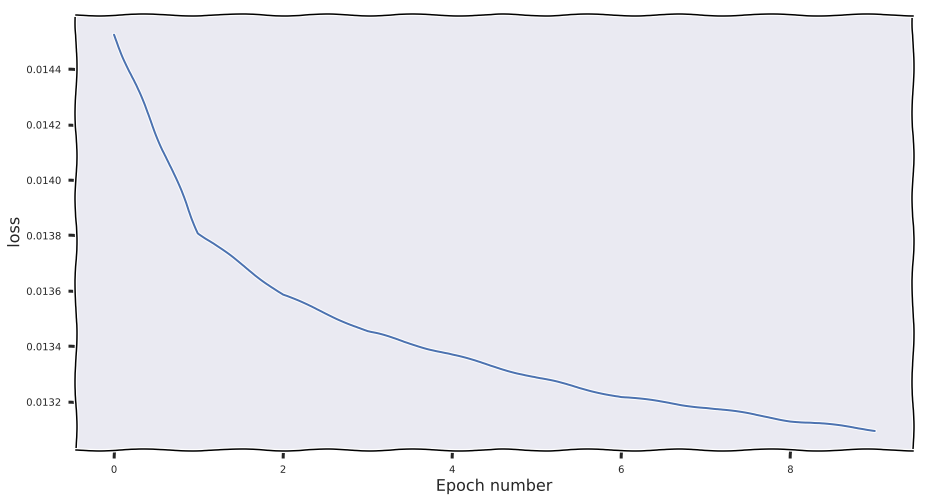

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

with plt.xkcd():
  fig = plt.figure(figsize=(15, 8))
  plt.plot(loss_history)
  plt.xlabel("Epoch number", fontsize='16')
  plt.ylabel("loss", fontsize='16')
  plt.show()

Напишем функцию, которая применит сеть к тестовым данным и получит ответы:

In [0]:
def predict(net, test_loader):
  # сохраним все предсказания в один список
  preds = []
  # переводим сеть в режим применения (inference)
  net.eval()
  with tqdm(desc="Predict", total=len(test_loader)) as pbar:
    for batch in test_loader:
      # нам пока нужны только изображения, метки нужны будут на этапе расчета метрик
      data, _ = batch
      data = data.cuda()
      out = net(data)
      # возвращаем тензор с видеокарты и превращаем его в numpy-массив, добавляем в список
      # .cpu() возвращает тензор с видеокарты
      # .detach() и .numpy() нужно использовать, чтобы превратить тензор в обычный массив
      preds.append(out.cpu().detach().numpy())
      pbar.update()
  # объединяем список в один numpy-массив, содержащий вероятности принадлежности каждому из 10-ти классов для каждого примера в тестовой выборке
  preds = np.concatenate(preds)
  return preds

Сначала применим обученную сеть к обучающей же выборке и посмотрим, каких метрик сеть достигла на трейне:

In [21]:
# пересоздаем даталоадер для трейн датасета, чтобы отключить случайную последовательность пакето (это перемешает последовательность меток и метрики будут неправильными)
train_eval_loader = torch.utils.data.DataLoader(cifar10_train, batch_size=128)
probs_train = predict(net, train_eval_loader)
print(probs_train.shape)

Predict: 100%|██████████| 391/391 [00:13<00:00, 28.13it/s]

(50000, 10)


Размерность probs_train будет (50000, 10) - 50 тысяч примеров по 10 вероятностей принадлежности классам. Теперь превратим это в конкретные метки, выбрав для каждого примера ту метку, для которой вероятность максимальная:

In [22]:
pred_train = np.argmax(probs_train, axis=1)
print(pred_train.shape)

(50000,)


Вытащим из cifar10_train датасета правильные ответы:

In [19]:
# пройтись по всему cifar10_train датасету, взять по второму элементу (метка класса) и сложить все в один список:
true_train = [data[1] for data in cifar10_train]
print(len(true_train))

50000


In [25]:
from sklearn.metrics import accuracy_score, classification_report

# считаем метрики - долю правильный ответов и точность, полноту и F-меру по классам:
print(f"Доля правильных ответов (accuracy) на трейне: {accuracy_score(true_train, pred_train)*100}%")
print(classification_report(true_train, pred_train, target_names=classes))

Доля правильных ответов (accuracy) на трейне: 43.504%
              precision    recall  f1-score   support

       plane       0.51      0.45      0.47      5000
         car       0.45      0.57      0.50      5000
        bird       0.36      0.24      0.29      5000
         cat       0.36      0.27      0.31      5000
        deer       0.38      0.39      0.38      5000
         dog       0.41      0.29      0.34      5000
        frog       0.39      0.59      0.47      5000
       horse       0.48      0.48      0.48      5000
        ship       0.51      0.58      0.54      5000
       truck       0.47      0.50      0.48      5000

   micro avg       0.44      0.44      0.44     50000
   macro avg       0.43      0.44      0.43     50000
weighted avg       0.43      0.44      0.43     50000



Теперь повторим все это для тестовой выборки и получим финальные оценки качества сети на этой задаче:

In [26]:
probs_test = predict(net, test_loader)
pred_test = np.argmax(probs_test, axis=1)
# пройтись по всему cifar10_train датасету, взять по второму элементу (метка класса) и сложить все в один список:
true_test = [data[1] for data in cifar10_test]
# считаем метрики - долю правильный ответов и точность, полноту и F-меру по классам:
print(f"Доля правильных ответов (accuracy) на тесте: {accuracy_score(true_test, pred_test)*100}%")
print(classification_report(true_test, pred_test, target_names=classes))

Predict: 100%|██████████| 79/79 [00:02<00:00, 29.39it/s]


Доля правильных ответов (accuracy) на тесте: 40.83%
              precision    recall  f1-score   support

       plane       0.47      0.41      0.44      1000
         car       0.44      0.53      0.48      1000
        bird       0.32      0.21      0.26      1000
         cat       0.32      0.24      0.27      1000
        deer       0.35      0.35      0.35      1000
         dog       0.39      0.29      0.33      1000
        frog       0.37      0.57      0.45      1000
       horse       0.46      0.46      0.46      1000
        ship       0.49      0.57      0.52      1000
       truck       0.44      0.46      0.45      1000

   micro avg       0.41      0.41      0.41     10000
   macro avg       0.40      0.41      0.40     10000
weighted avg       0.40      0.41      0.40     10000



Итого ~40% точности. Не случайный классификатор, то тоже не особо хорошо для такой простой задачи. При этом разрыв между качеством на трейне и тесте небольшой, что говорит что мы не свалились в переобучение, а просто емкости однослойной сети не хватает для решения подобной задачи. Это логично - однослойная сеть как и линейный классификатор, умеет хорошо решать только линейно разделимые задачи, что для изображений явно не выполняется.


---



**ЗАДАНИЕ 1:** поиграйтесь с параметрами обучения однослойной сети. Посмотрите, как размер batch_size влияет на скорость обучения и его качество, а также как влияет learning_rate. Попробуйте поставить learning_rate очень большим и посмотреть, что происходит. Насколько большим можно поставить learning_rate чтобы сеть не сломалась?

---



## Двухслойная сеть

Теперь построим двухслойную сеть точно так же, как и однослойную:

In [0]:
class TwoLayerNet(nn.Module):
  
  def __init__(self, input_dim, hidden_dim, out_dim):
    super().__init__()
    # размерности должны быть согласованы между слоями (hidden_dim)
    self.linear1 = nn.Linear(in_features=input_dim, out_features=hidden_dim)
    # в качестве промежуточной функции активации будем использовать ReLU:
    self.relu = nn.ReLU()
    self.linear2 = nn.Linear(in_features=hidden_dim, out_features=out_dim)
    self.softmax = nn.Softmax(dim=1)
    
  def forward(self, x): 
    h = self.linear1(x)
    # применяем ReLU к выходам первого слоя
    h = self.relu(h)
    # и отправляем во второй слой
    out = self.linear2(h)
    if self.training:
      return out
    else:
      return self.softmax(out)

Используем для обучения и проверки уже готовые функции:

In [28]:
net2 = TwoLayerNet(input_dim=32*32*3, hidden_dim=50, out_dim=10).cuda()
loss_history = train_net(net2, train_loader, loss_function, num_epochs=10, learning_rate=2e-4)

Epoch 10: 100%|██████████| 391/391 [00:17<00:00, 22.79it/s, loss=0.0107]


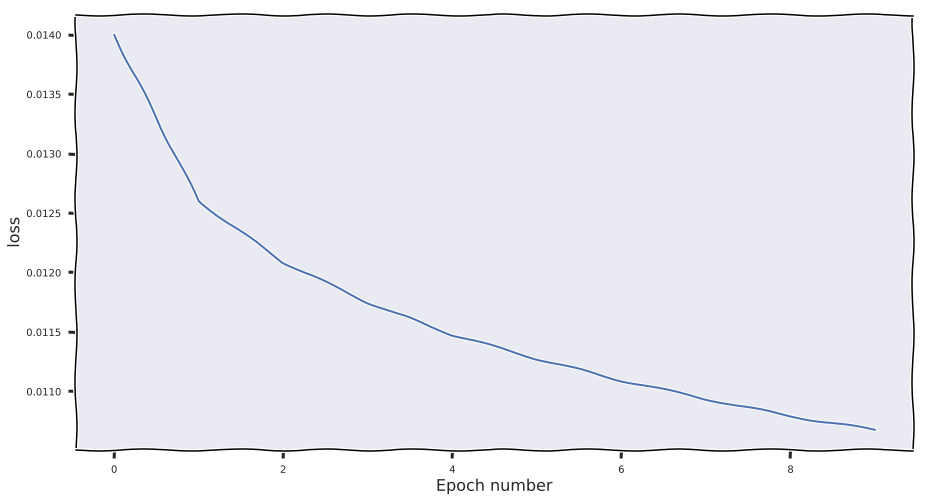

In [29]:
with plt.xkcd():
  fig = plt.figure(figsize=(15, 8))
  plt.plot(loss_history)
  plt.xlabel("Epoch number", fontsize='16')
  plt.ylabel("loss", fontsize='16')
  plt.show()

Функция ошибки уменьшилась сильнее, чем в случае с однослойной сетью - это значит, что сеть должна была обучиться лучше. Смотрим на качество на трейне и тесте:

In [30]:
probs_train = predict(net2, train_eval_loader)
pred_train = np.argmax(probs_train, axis=1)
# пройтись по всему cifar10_train датасету, взять по второму элементу (метка класса) и сложить все в один список:
true_train = [data[1] for data in cifar10_train]
# считаем метрики - долю правильный ответов и точность, полноту и F-меру по классам:
print(f"Доля правильных ответов (accuracy) на трейне: {accuracy_score(true_train, pred_train)*100}%")
print(classification_report(true_train, pred_train, target_names=classes))

Predict: 100%|██████████| 391/391 [00:13<00:00, 28.41it/s]


Доля правильных ответов (accuracy) на трейне: 53.504%
              precision    recall  f1-score   support

       plane       0.59      0.58      0.58      5000
         car       0.61      0.68      0.64      5000
        bird       0.45      0.35      0.40      5000
         cat       0.41      0.35      0.38      5000
        deer       0.45      0.46      0.46      5000
         dog       0.47      0.40      0.43      5000
        frog       0.51      0.60      0.55      5000
       horse       0.56      0.65      0.60      5000
        ship       0.64      0.69      0.67      5000
       truck       0.58      0.60      0.59      5000

   micro avg       0.54      0.54      0.54     50000
   macro avg       0.53      0.54      0.53     50000
weighted avg       0.53      0.54      0.53     50000



In [31]:
probs_test = predict(net2, test_loader)
pred_test = np.argmax(probs_test, axis=1)
# пройтись по всему cifar10_train датасету, взять по второму элементу (метка класса) и сложить все в один список:
true_test = [data[1] for data in cifar10_test]
# считаем метрики - долю правильный ответов и точность, полноту и F-меру по классам:
print(f"Доля правильных ответов (accuracy) на тесте: {accuracy_score(true_test, pred_test)*100}%")
print(classification_report(true_test, pred_test, target_names=classes))

Predict: 100%|██████████| 79/79 [00:02<00:00, 27.59it/s]


Доля правильных ответов (accuracy) на тесте: 48.61%
              precision    recall  f1-score   support

       plane       0.56      0.54      0.55      1000
         car       0.55      0.61      0.58      1000
        bird       0.40      0.32      0.35      1000
         cat       0.37      0.30      0.33      1000
        deer       0.40      0.39      0.40      1000
         dog       0.42      0.36      0.39      1000
        frog       0.48      0.57      0.52      1000
       horse       0.51      0.59      0.54      1000
        ship       0.59      0.65      0.62      1000
       truck       0.53      0.53      0.53      1000

   micro avg       0.49      0.49      0.49     10000
   macro avg       0.48      0.49      0.48     10000
weighted avg       0.48      0.49      0.48     10000



Получили прибавку в почти ~10% как на трейне, так и на тесте, что очень хорошо (хотя суммарное качество в 50% все равно не удовлетворительное для каких-либо задач реального мира - но это просто потому что полносвязные нейронные сети не лучший выбор для анализа изображений, есть архитектуры куда более подходящие, об этом в следующий раз). При этом разрыв между трейном и тестом увеличился до 4,5% - возможно, сеть начинает немного переучиваться.


---



**ЗАДАНИЕ 2:** посмотрите влияние параметров на процесс обучения и качество двухслойной сети. Попробуйте подобрать такие параметры (batch_size, hidden_dim. learning_rate) чтобы получить лучшее качество на тесте.


---



**ЗАДАНИЕ 3:** основываясь на примерах выше, напишите **трехслойную** (или еще более глубокую, если хотите, тут вы ограничены только вычислительными ресурсами Colab) сеть, и подберите такие параметры, чтобы получить максимальную долю правильных ответов (accuracy) на **тесте**.